In [1]:
from src import tpu_setup

In [5]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [7]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)


def train_mnist():
  torch.manual_seed(1)
  
  if not xm.is_master_ordinal():
    # Barrier: Wait until master is done downloading
    xm.rendezvous('download_only_once')

  # Get and shard dataset into dataloaders
  norm = transforms.Normalize((0.1307,), (0.3081,))
  train_dataset = datasets.MNIST(
      FLAGS['datadir'],
      train=True,
      download=True,
      transform=transforms.Compose(
          [transforms.ToTensor(), norm]))
  test_dataset = datasets.MNIST(
      FLAGS['datadir'],
      train=False,
      download=True,
      transform=transforms.Compose(
          [transforms.ToTensor(), norm]))
  
  if xm.is_master_ordinal():
    # Barrier: Master done downloading, other workers can proceed
    xm.rendezvous('download_only_once')

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = MNIST().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [8]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

 GlobalRate=186.27 Time=Wed May 13 22:36:36 2020
[xla:2](0) Loss=0.17236 Rate=180.31 GlobalRate=180.30 Time=Wed May 13 22:36:36 2020
[xla:6](20) Loss=0.06498 Rate=2428.21 GlobalRate=1969.62 Time=Wed May 13 22:36:37 2020
[xla:5](20) Loss=0.15600 Rate=2433.74 GlobalRate=2008.61 Time=Wed May 13 22:36:37 2020
[xla:0](20) Loss=0.13816 Rate=2410.88 GlobalRate=1970.47 Time=Wed May 13 22:36:37 2020
[xla:7](20) Loss=0.14673 Rate=2374.59 GlobalRate=1970.62 Time=Wed May 13 22:36:37 2020
[xla:3](20) Loss=0.15537 Rate=2395.19 GlobalRate=1977.63 Time=Wed May 13 22:36:37 2020
[xla:1](20) Loss=0.08047 Rate=2194.95 GlobalRate=1986.06 Time=Wed May 13 22:36:37 2020
[xla:4](20) Loss=0.13028 Rate=2418.67 GlobalRate=2024.38 Time=Wed May 13 22:36:37 2020
[xla:2](20) Loss=0.15555 Rate=2421.44 GlobalRate=1971.08 Time=Wed May 13 22:36:37 2020
[xla:5](40) Loss=0.08765 Rate=3237.39 GlobalRate=2602.24 Time=Wed May 13 22:36:38 2020
[xla:4](40) Loss=0.04056 Rate=3245.25 GlobalRate=2621.18 Time=Wed May 13 22:36:38 20

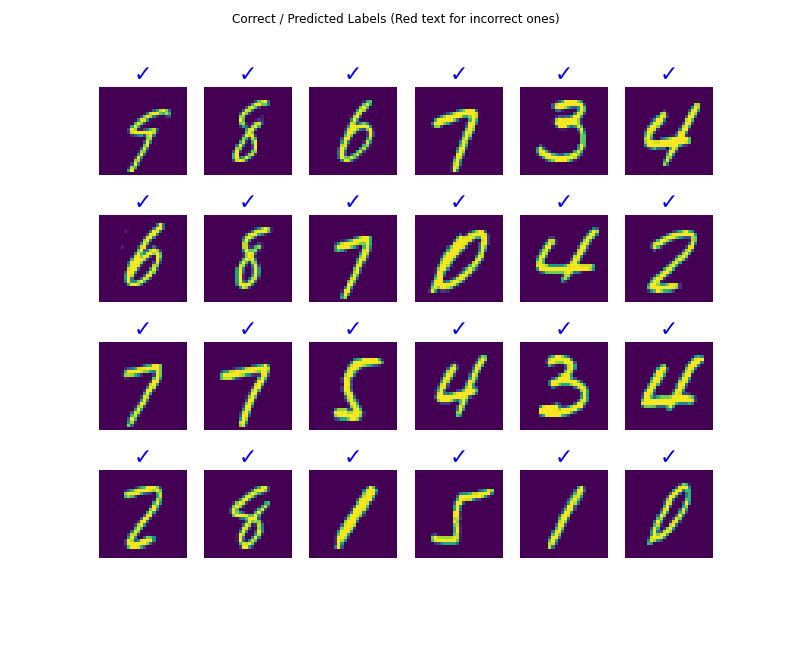

In [11]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [2]:
import os

In [3]:
import torch
import torch.nn as nn
import transformers
from transformers import BertModel,BertTokenizer,BertForMaskedLM

In [4]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

In [5]:
model=BertModel.from_pretrained("bert-base-uncased")

In [8]:
text='hello how are you doing today ?'
inp = tokenizer.encode_plus(text)

In [7]:
model.eval()
model=model.cuda()

In [17]:
opt = model(torch.tensor([inp["input_ids"]]).cuda(),token_type_ids=torch.tensor([inp["token_type_ids"]]).cuda())

In [28]:
print(opt)

(tensor([[[ 0.0651, -0.0272, -0.1041,  ..., -0.4704,  0.1531,  0.4379],
         [ 0.3265,  0.2510,  0.4010,  ..., -0.5542,  0.8715,  0.0646],
         [ 0.0431, -0.6628, -0.0623,  ..., -0.2092,  0.4100, -0.9200],
         ...,
         [-0.1852, -0.7003, -0.8145,  ..., -0.2869, -0.0099, -0.6238],
         [-0.3100, -0.9521, -0.7391,  ...,  0.0435,  0.0570, -0.1790],
         [ 0.4934, -0.1540, -0.3637,  ...,  0.1522, -0.4075, -0.2111]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward>), tensor([[-0.9325, -0.4461, -0.8715,  0.8512,  0.6705, -0.2263,  0.9285,  0.2642,
         -0.7471, -1.0000, -0.4472,  0.9657,  0.9846,  0.4387,  0.9663, -0.8510,
         -0.6889, -0.6225,  0.2675, -0.5856,  0.7629,  1.0000,  0.1583,  0.2933,
          0.3993,  0.9950, -0.9026,  0.9678,  0.9738,  0.7256, -0.7606,  0.0956,
         -0.9940, -0.1838, -0.9069, -0.9930,  0.4059, -0.7753,  0.0047,  0.0327,
         -0.9341,  0.2766,  1.0000, -0.2391,  0.4447, -0.2714, -1.0000,  0.2491,
         -0